### Import Libraries

In [1]:
!pip install tensorflow-text==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 8.1 MB/s 
     |████████████████████████████████| 516.4 MB 18 kB/s 
     |████████████████████████████████| 454 kB 67.7 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 2.9 MB 22.6 MB/s 
     |████████████████████████████████| 3.0 MB 55.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall:

In [23]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import dfutilities
from sklearn.model_selection import train_test_split
from cf_matrix import make_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

### Load Data 
1. We have Predicted Labels, data generated from Acitve learning on transformers with small-text library
2. We have Manual Annotated data which will act as test dataset to evaluate the performance of BERT model

In [4]:
train_path = "/content/PredictedLabels_WithAL.csv"
test_path = "/content/ManualAnnotatedData.csv"

In [5]:
dfHandler = dfutilities.dfUtil()
df_train,df_test,log = dfHandler.handle_data(train_path,test_path)

In [6]:
log

['Length of Train Dataset : 60123',
 'Length of Test Dataset : 3200',
 'Number of Null Values in Train Dataset : 0',
 'Number of Null Values in Test Dataset : 0']

In [7]:
#Get only relevant fields
df_train = df_train[['CleanText','Label']]

In [8]:
df_train['Label'].value_counts()

0    35923
1    24200
Name: Label, dtype: int64

### Split train data for train and validate

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_train['CleanText'],df_train['Label'], stratify=df_train['Label'])

In [11]:
print(len(X_train))

45092


### Model Training
Tokenization, Encoding

In [12]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [13]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [14]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'encoder_outputs':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

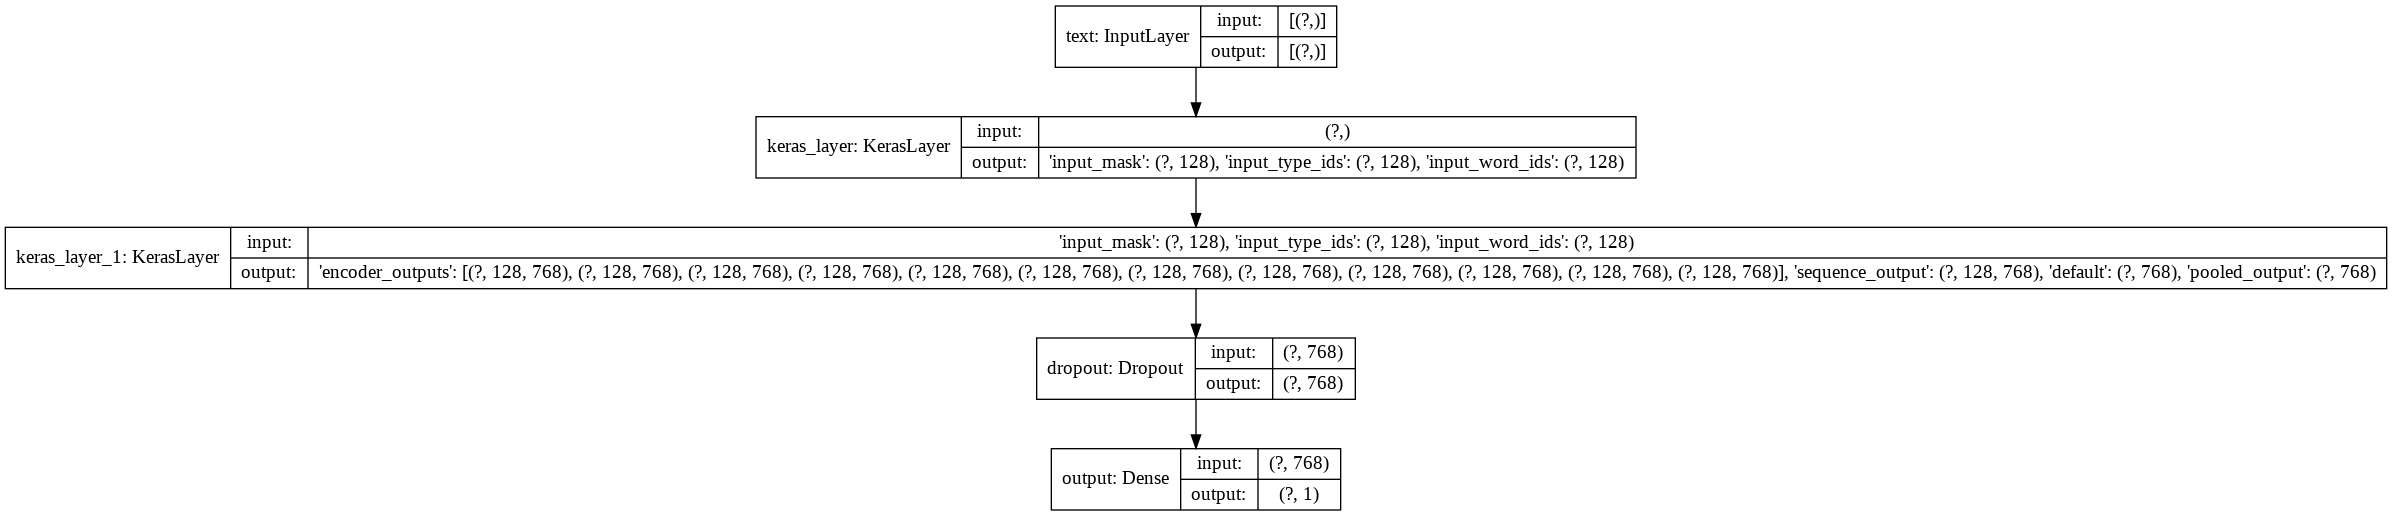

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
model.fit(X_train, y_train, epochs=4)

Epoch 1/4
1410/1410 [==============================] - 254s 180ms/step - loss: 0.2746 - accuracy: 0.8878
Epoch 2/4
1410/1410 [==============================] - 244s 173ms/step - loss: 0.1822 - accuracy: 0.9256
Epoch 3/4
1410/1410 [==============================] - 245s 173ms/step - loss: 0.1651 - accuracy: 0.9315
Epoch 4/4
1410/1410 [==============================] - 245s 174ms/step - loss: 0.1566 - accuracy: 0.9349


In [19]:
model.evaluate(X_test, y_test)

470/470 [==============================] - 81s 173ms/step - loss: 0.1373 - accuracy: 0.9451


[0.13729636371135712, 0.9451134204864502]

### Check the performance on the test data


In [20]:
X_test = df_test['CleanText']
y_true = df_test['Label']
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)

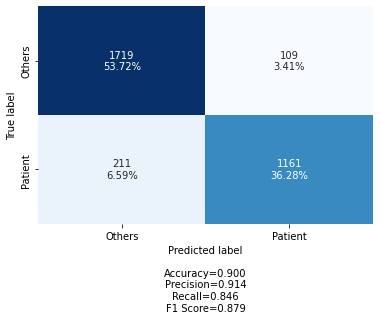

In [24]:
#labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Others', 'Patient']
cm = confusion_matrix(y_predicted,y_true)
make_confusion_matrix(cm, cbar=False,
                      #group_names=labels,
                      categories=categories, 
                      cmap='Blues')